In [1]:
%matplotlib inline
import Euclid
import matplotlib.pyplot as plt
import numpy as np

from collections import namedtuple
from glob import glob
from matplotlib import colors
from astropy.table import Table
from tqdm.notebook import tqdm
from scipy.stats import gaussian_kde

%elogin
%erun PHZ_NNPZ

from nnpz.reference_sample.ReferenceSample import ReferenceSample
from nnpz.photometry.ListFileFilterProvider import ListFileFilterProvider
from nnpz.photometry.FnuuJyPrePostProcessor import FnuuJyPrePostProcessor
from nnpz.photometry.ReferenceSampleParallelPhotometryBuilder import ReferenceSamplePhotometryParallelBuilder as PhotometryBuilder

plt.rcParams['figure.figsize'] = (20, 10)

class TqdmWrapper(object):
    def __init__(self, total):
        self.tqdm = tqdm(total=total)
        self.progress = 0
        
    def __call__(self, n):
        self.tqdm.update(n - self.progress)
        self.progress = n

Iter = namedtuple('Iter', ['sed'])

In [2]:
ref_sample = ReferenceSample('/home/aalvarez/Work/Data/SC8/PHZ_Calibration/MergeReferenceSampleDirs/reference_sample_dir.dir/')
ref_photo = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Calibration/BuildReferenceSamplePhotometry/reference_sample_phot.fits')

WARN: hdu= was not specified but multiple tables are present, reading in first available table (hdu=1) [astropy.io.fits.connect]
WARN    : hdu= was not specified but multiple tables are present, reading in first available table (hdu=1)
2020-08-05T16:54:29CEST astropy  WARN : hdu= was not specified but multiple tables are present, reading in first available table (hdu=1)


In [3]:
# Filter Provider
subaru_trans_files = glob('/home/aalvarez/Phosphoros/AuxiliaryData/Filters/Subaru/IB*.dat') + glob('/home/aalvarez/Phosphoros/AuxiliaryData/Filters/euclid/*.dat')
with open('/tmp/filter_list.txt', 'wt') as fd:
    fd.write('\n'.join(subaru_trans_files))
filter_provider = ListFileFilterProvider('/tmp/filter_list.txt')

# Photometry
fnuu = FnuuJyPrePostProcessor()

In [4]:
# Builder
photo_builder = PhotometryBuilder(filter_provider, fnuu, ncores=2)

In [32]:
# Get object
obj_id = ref_sample.getIds()[20]
sed_z = ref_sample.getSedData(obj_id)
pdz = ref_sample.getPdzData(obj_id)
photo = ref_photo[ref_photo['ID'] == obj_id][0]
# SED corresponds to max PDZ (?)
ref_z = pdz[:,0][pdz[:,1].argmax()]
# Un-shift SED
sed = np.copy(sed_z)
sed[:, 0] /= 1 + ref_z
sed[:, 1] *= (1 + ref_z)**2

In [33]:
normed_pdz = pdz[:,1] / np.sum(pdz[:,1])
zpicks = np.random.choice(pdz[:,0], 10000, p=normed_pdz)
zseds = list([Iter(sed=np.stack([sed[:, 0] * (z + 1), sed[:,1] / (1 + z)**2], axis=1)) for z in zpicks])

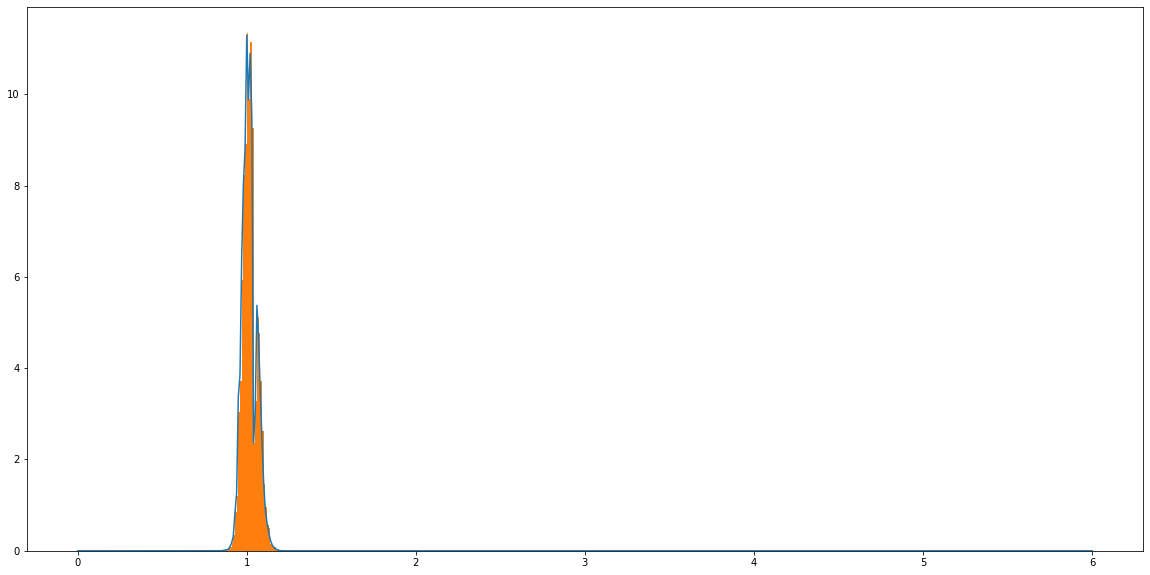

In [34]:
plt.figure()
plt.plot(pdz[:,0], pdz[:,1])
plt.hist(zpicks, bins=pdz[:,0], density=True)
plt.show()

In [35]:
ret = photo_builder.buildPhotometry(zseds, progress_listener=TqdmWrapper(len(zseds)))

INFO    : Computing photometries using 2 processes
2020-08-05T17:00:19CEST BuildPhotometry  INFO : Computing photometries using 2 processes


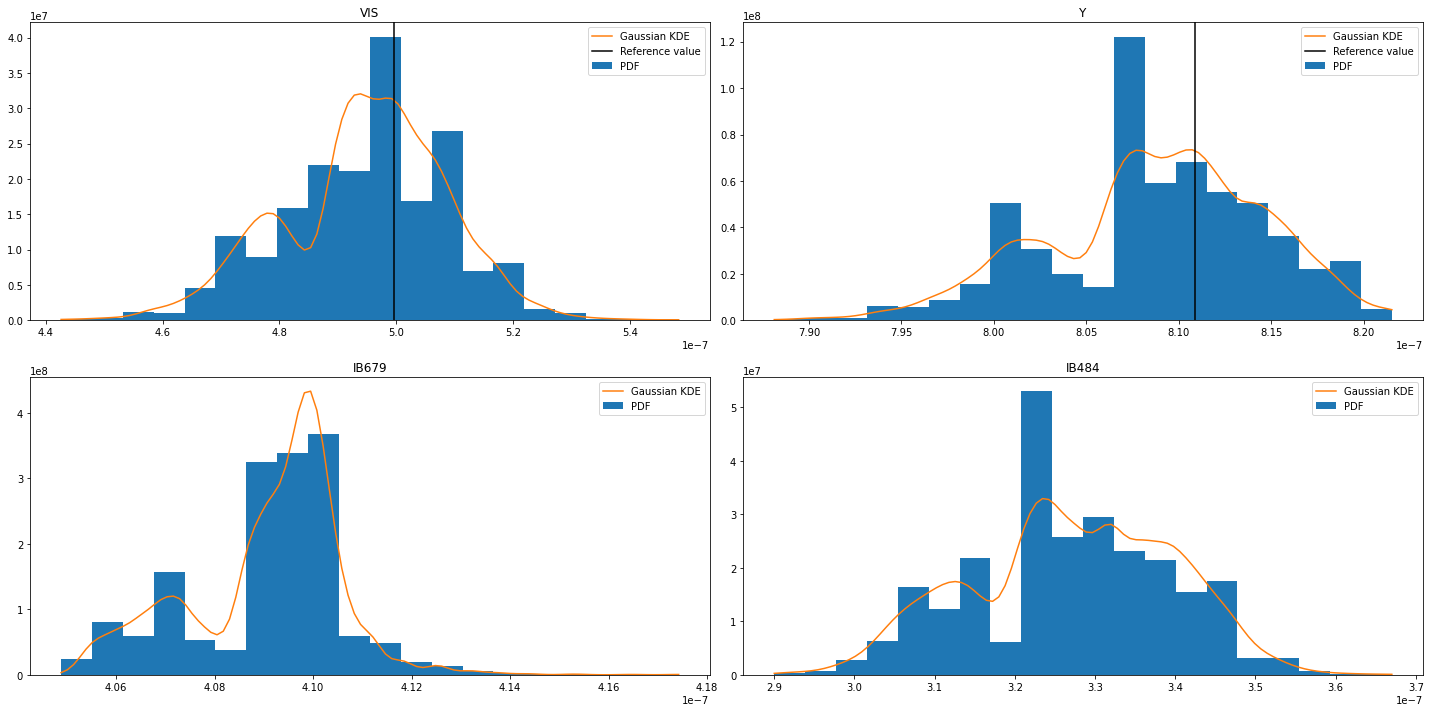

In [36]:
fig, axes = plt.subplots(ncols=2, nrows=2)
for ax, band in zip(axes.ravel(), ['VIS', 'Y', 'IB679', 'IB484']):
    bins = ax.hist(ret[band], bins=20, label='PDF', density=True)
    kx = np.linspace(np.min(bins[1]), np.max(bins[1]), 100)
    kernel = gaussian_kde(ret[band])
    ax.plot(kx, kernel(kx), label='Gaussian KDE')
    if not band.startswith('IB'):
        ax.axvline(photo[f'euclid/{band}'], color='black', label='Reference value')
    ax.set_title(band)
    ax.legend()
plt.tight_layout()
plt.show()